<a href="https://colab.research.google.com/github/sharon-kurant/VCE_Remission_Classification/blob/main/custom_train_VCE_classification_with_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [4]:
args = { "num_frames" : 16,
         "batch_size" : 2,
         "multiplier" : 2,
         "tagged_dir" : '/content/drive/MyDrive/remission/data',
         "video_dir" : '/content/drive/MyDrive/remission/data_5fps'
}

In [5]:
num_frames = args["num_frames"]
batch_size = args["batch_size"]
multiplier = args["multiplier"]
tagged_dir = args["tagged_dir"]
video_dir = args["video_dir"]

In [6]:
# video_files = glob.glob(f'/content/drive/MyDrive/remission/data/**/**/*.mp4') * 6
# len([str(path).split("/")[-2] for path in video_files])

In [6]:
class VideoDataset(Dataset):
    def __init__(self, video_dir, num_frames=64, tagged_dir = '/content/drive/MyDrive/remission/data', transform=None, multiplier = 5):
        self.video_dir = video_dir
        self.num_frames = num_frames
        self.transform = transform
        self.multiplier = multiplier
        # List all video files in the directory
        self.video_files = glob.glob(f'{tagged_dir}/**/**/*.mp4') * self.multiplier

        class_labels = sorted({str(path).split("/")[-2] for path in self.video_files})
        self.label2id = {label: i for i, label in enumerate(class_labels)}
        self.id2label = {i: label for label, i in self.label2id.items()}

        self.labels = [str(path).split("/")[-2] for path in self.video_files] * self.multiplier

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):

        video_file = self.video_files[idx]
        video_path = os.path.join(self.video_dir, video_file)

        # Open the video file
        cap = cv2.VideoCapture(video_path)

        # Get the total number of frames in the video
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Randomly select num_frames from equally divided intervals
        intervals = np.linspace(0, total_frames, self.num_frames + 1, dtype=int)
        frame_indices = [torch.randint(low=intervals[i], high=intervals[i + 1], size=(1,)) for i in range(self.num_frames)]
        frame_indices = torch.concatenate(frame_indices)

        # Initialize empty frame list
        frames = []

        # Read frames
        for i in range(self.num_frames):
            # Set the frame position
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)

            # Read the frame
            ret, frame = cap.read()

            if not ret:
                # Handle the case where reading the frame fails
                raise RuntimeError(f"Failed to read frame {i} from video {video_file}")

            # Convert the frame from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            if self.transform:
              frame = self.transform(frame)
            # Append the frame to the list of frames
            frames.append(frame)

        # Close the video file
        cap.release()

        # Convert frames to a tensor
        frames = torch.stack(frames)

        return frames, self.label2id[self.labels[idx]]


In [7]:
# Define transformations
transform = transforms.Compose([
    # Add any transformations you need (e.g., normalization, resizing)
    transforms.ToPILImage(),
    transforms.CenterCrop((510,510)),
    # transforms.RandomCrop(224),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define your dataset and DataLoader
# num_classes = 2  # Adjust based on your classification task

dataset = VideoDataset(video_dir, num_frames=num_frames, transform=transform, multiplier=multiplier)

In [8]:
# from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import AutoImageProcessor, TimesformerForVideoClassification

In [14]:
model_ckpt = 'facebook/timesformer-hr-finetuned-ssv2' # "fcakyon/timesformer-large-finetuned-ssv2"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = TimesformerForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=dataset.label2id,
    id2label=dataset.id2label,
    output_hidden_states=True,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=1, bias=True),
    nn.Sigmoid(),
)

# model.classifier = nn.Sequential(
#     nn.Linear(in_features=768, out_features=512, bias=True),
#     nn.Dropout(0.3),
#     nn.Linear(in_features=512, out_features=256, bias=True),
#     nn.Dropout(0.3),
#     # nn.Linear(in_features=256, out_features=128, bias=True),
#     # nn.Dropout(0.3),
#     nn.Linear(in_features=256, out_features=1, bias=True,),
#     nn.Sigmoid(),
# )

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-hr-finetuned-ssv2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([174, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([174]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
class_weights = torch.tensor(61 / (2 * np.array([44,17])), dtype=torch.float).to(device='cuda')
class_weights

tensor([0.6932, 1.7941], device='cuda:0')

In [ ]:
all_labels_train = np.array([1,0,1,0,1,1,1,0,0,1])
all_probs_train = np.array([0.9,0.1,0.9,0.1,0.9,0.9,0.9,0.1,0.1,0.9])

accuracy_score(all_labels_train, all_probs_train)

In [15]:
num_epochs = 1

# Define your model, loss function, and optimizer

class_weights = torch.tensor(61 / (2 * np.array([44,17])), dtype=torch.float).to(device='cuda')
criterion = nn.BCELoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# Set the number of videos in the dataset (adjust as needed)
dataset_videos_amount = 61
# Set the number of folds
num_folds = 5

# Use KFold for 5-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)

# Initialize lists to store metrics
train_losses = []
train_aucs = []
train_accuracies = []

val_losses = []
val_aucs = []
val_accuracies = []

model.cuda()
# Training loop
for fold, (train_indices, val_indices) in enumerate(kf.split(range(dataset_videos_amount))):
    print(f"Fold {fold + 1}")

    train_examples = np.array([train_index + (r*61) for train_index in train_indices for r in range(multiplier)])
    val_examples = np.array([val_index + (r*61) for val_index in val_indices for r in range(multiplier)])

    # Split the dataset into training and validation sets
    train_set = torch.utils.data.Subset(dataset, train_examples)
    val_set = torch.utils.data.Subset(dataset, val_examples)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Training for the current fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels_train = []
        all_probs_train = []

        # Use tqdm for progress visualization
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            frames, labels = batch

            # Move data to CUDA
            frames, labels = frames.cuda(), labels.float().cuda()

            # Forward pass
            outputs = model(frames)

            # Compute the loss
            loss = criterion(outputs.logits.squeeze(), labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Get predicted probabilities for metrics
            probs_train = outputs.logits.squeeze().detach().cpu().numpy()
            all_labels_train.extend(labels.cpu().numpy())
            all_probs_train.extend(list(probs_train))

        # Calculate AUC and accuracy for training
        train_auc = roc_auc_score(all_labels_train, np.array(all_probs_train))
        train_accuracy = accuracy_score(all_labels_train, np.array(all_probs_train) > 0.5)

        # Average training loss for the epoch
        avg_train_loss = running_loss / len(train_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.3f}, AUC: {train_auc:.3f}, Accuracy: {train_accuracy:.3f}")

        # Save metrics for training
        train_losses.append(avg_train_loss)
        train_aucs.append(train_auc)
        train_accuracies.append(train_accuracy)

        # Validation for the current fold
        model.eval()
        running_loss_val = 0.0
        all_labels_val = []
        all_probs_val = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                frames, labels = batch

                # Move data to CUDA
                frames, labels = frames.cuda(), labels.float().cuda()

                # Forward pass
                outputs = model(frames)

                # Compute the loss for validation
                loss_val = criterion(outputs.logits.squeeze(), labels)
                running_loss_val += loss_val.item()

                # Get predicted probabilities for metrics
                probs_val = outputs.logits.squeeze().cpu().numpy()
                all_labels_val.extend(labels.cpu().numpy())
                all_probs_val.extend(list(probs_val))

        # Calculate AUC and accuracy
        val_auc = roc_auc_score(all_labels_val[::multiplier],
                            np.array(all_probs_val)
                            .reshape(-1,multiplier)
                            .mean(axis=1))
        val_accuracy = accuracy_score(all_labels_val[::multiplier],
                                  (np.array(all_probs_val)
                                  .reshape(-1,multiplier)
                                  .mean(axis=1) > 0.5)
                                  .astype(int))

        # Average validation loss for the epoch
        avg_val_loss = running_loss_val / len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.3f}, AUC: {val_auc:.3f}, Accuracy: {val_accuracy:.3f}")

        # Save metrics for validation
        val_losses.append(avg_val_loss)
        val_aucs.append(val_auc)
        val_accuracies.append(val_accuracy)

Fold 1


Epoch 1/1 - Training: 100%|██████████| 48/48 [00:34<00:00,  1.39it/s]


Epoch 1/1, Training Loss: 0.957, AUC: 0.548, Accuracy: 0.646


Epoch 1/1 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 1/1, Validation Loss: 0.768, AUC: 0.694, Accuracy: 0.692
Fold 2


Epoch 1/1 - Training: 100%|██████████| 49/49 [00:34<00:00,  1.40it/s]


Epoch 1/1, Training Loss: 0.452, AUC: 0.893, Accuracy: 0.847


Epoch 1/1 - Validation: 100%|██████████| 12/12 [00:04<00:00,  2.55it/s]


Epoch 1/1, Validation Loss: 0.413, AUC: 0.963, Accuracy: 0.833
Fold 3


Epoch 1/1 - Training: 100%|██████████| 49/49 [00:35<00:00,  1.40it/s]


Epoch 1/1, Training Loss: 0.532, AUC: 0.873, Accuracy: 0.857


Epoch 1/1 - Validation: 100%|██████████| 12/12 [00:04<00:00,  2.54it/s]


Epoch 1/1, Validation Loss: 0.239, AUC: 1.000, Accuracy: 0.917
Fold 4


Epoch 1/1 - Training: 100%|██████████| 49/49 [00:35<00:00,  1.40it/s]


Epoch 1/1, Training Loss: 0.345, AUC: 0.929, Accuracy: 0.878


Epoch 1/1 - Validation: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]


Epoch 1/1, Validation Loss: 0.697, AUC: 1.000, Accuracy: 0.750
Fold 5


Epoch 1/1 - Training: 100%|██████████| 49/49 [00:35<00:00,  1.39it/s]


Epoch 1/1, Training Loss: 0.114, AUC: 0.993, Accuracy: 0.949


Epoch 1/1 - Validation: 100%|██████████| 12/12 [00:04<00:00,  2.48it/s]

Epoch 1/1, Validation Loss: 0.175, AUC: 1.000, Accuracy: 0.917


In [16]:
# Save metrics in JSON format
metrics_dict = {
    'train_losses': train_losses,
    'train_aucs': train_aucs,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_aucs': val_aucs,
    'val_accuracies': val_accuracies,
}

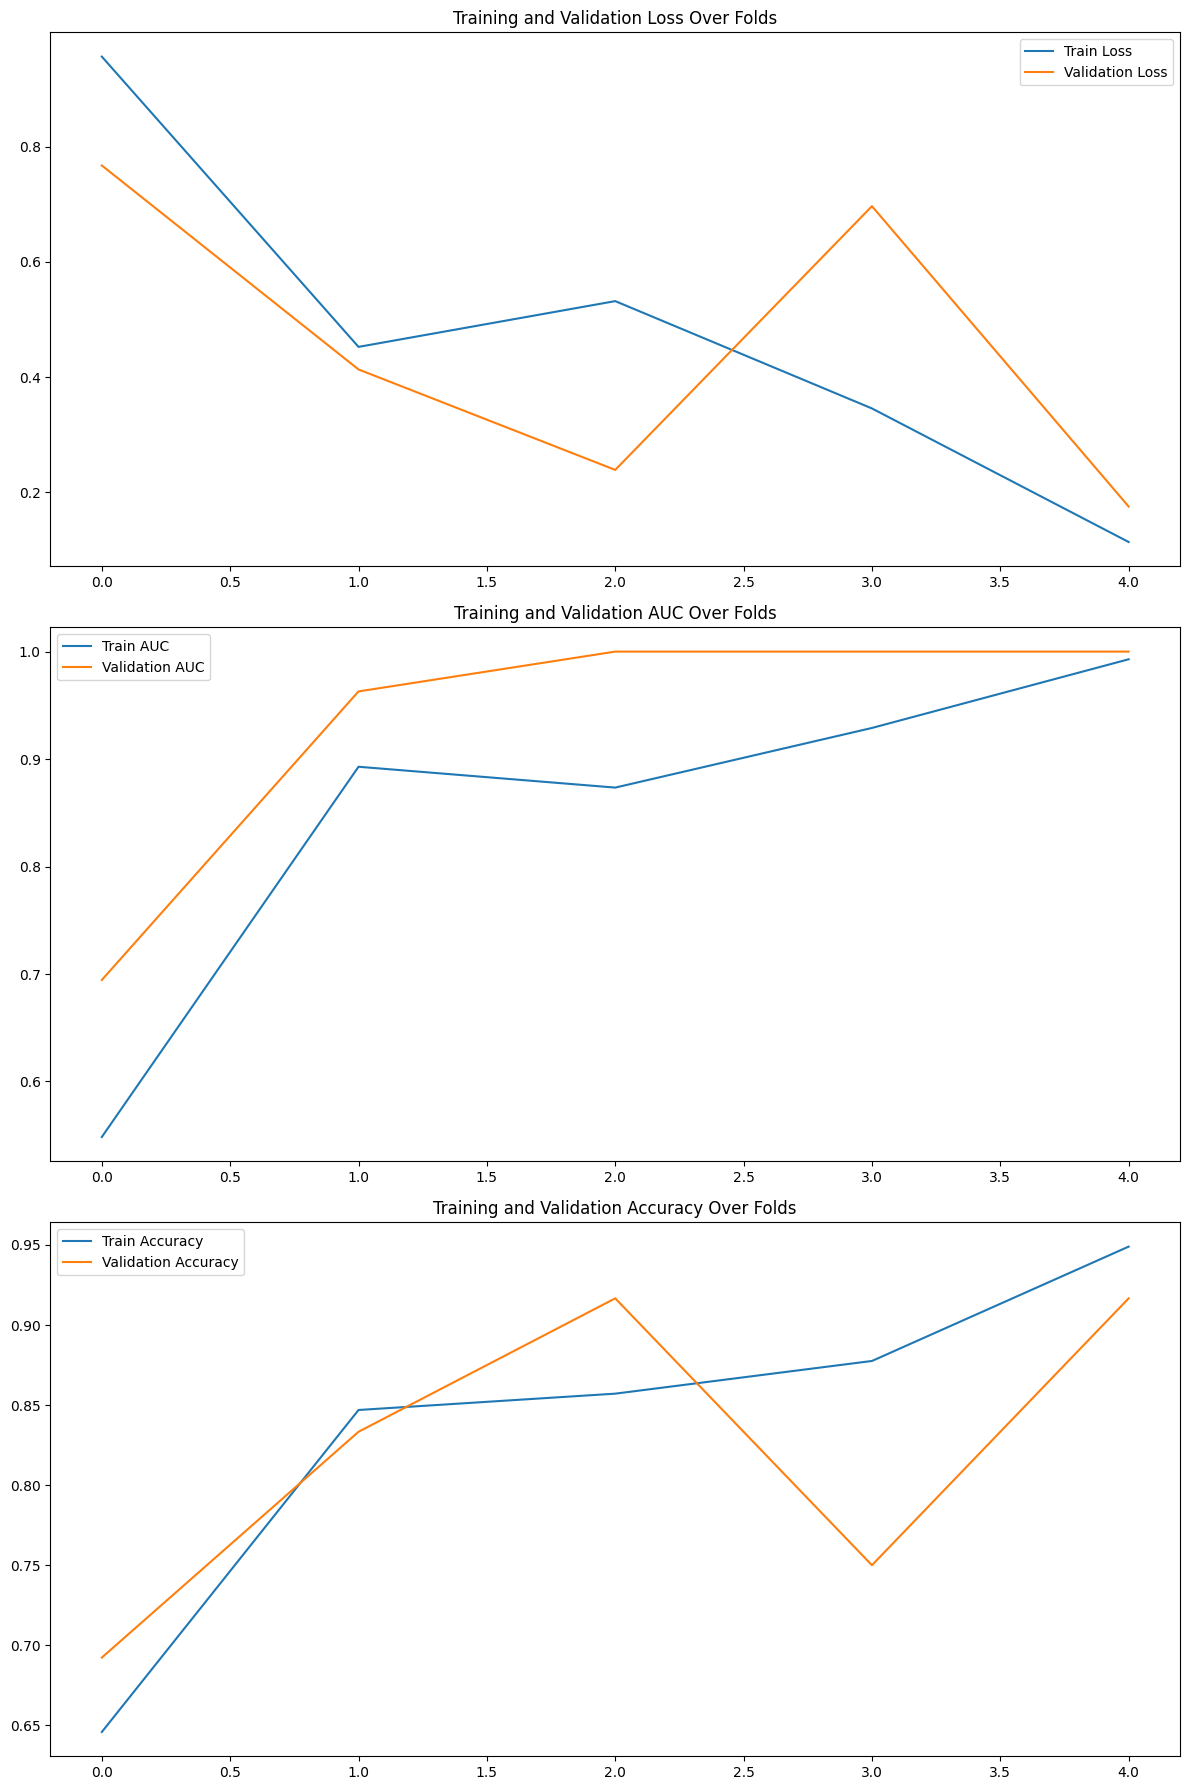

In [17]:
import json
import matplotlib.pyplot as plt

# Save metrics in JSON format
with open('metrics.json', 'w') as json_file:
    json.dump(metrics_dict, json_file)

# Plot metrics
plt.figure(figsize=(12, 18))

# Training Loss plot
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Folds')

# Training AUC plot
plt.subplot(3, 1, 2)
plt.plot(train_aucs, label='Train AUC')
plt.plot(val_aucs, label='Validation AUC')
plt.legend()
plt.title('Training and Validation AUC Over Folds')

# Training Accuracy plot
plt.subplot(3, 1, 3)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Folds')

# Adjust layout
plt.tight_layout()

# Save the plots as PNG files
plt.savefig('loss_auc_accuracy_plots.png')

# Show the plots
plt.show()

In [22]:
num_epochs = 1

# Define your model, loss function, and optimizer

class_weights = torch.tensor(61 / (2 * np.array([44,17])), dtype=torch.float).to(device='cuda')
criterion = nn.BCELoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Set the number of videos in the dataset (adjust as needed)
dataset_videos_amount = 61
# Set the number of folds
num_folds = 5

# Use KFold for 5-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
model.cuda()
# Training loop
for fold, (train_indices, val_indices) in enumerate(kf.split(range(dataset_videos_amount))):
    print(f"Fold {fold + 1}")

    train_examples = np.array([train_index + (r*61) for train_index in train_indices for r in range(multiplier)])
    val_examples = np.array([val_index + (r*61) for val_index in val_indices for r in range(multiplier)])
    # Split the dataset into training and validation sets
    train_set = torch.utils.data.Subset(dataset, train_examples)
    val_set = torch.utils.data.Subset(dataset, val_examples)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Training for the current fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Use tqdm for progress visualization
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            frames, labels = batch

            # Move data to CUDA
            frames, labels = frames.cuda(), labels.float().cuda()

            # Forward pass
            outputs = model(frames)

            # Compute the loss
            loss = criterion(outputs.logits.squeeze(), labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation for the current fold
        model.eval()
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                frames, labels = batch

                # Move data to CUDA
                frames, labels = frames.cuda(), labels.cuda()

                # Forward pass
                outputs = model(frames)

                # Get predicted probabilities
                # probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
                probs = outputs.logits.squeeze().cpu().numpy()
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(list(probs))

        # Calculate AUC and accuracy
        auc = roc_auc_score(all_labels[::multiplier],
                            np.array(all_probs)
                            .reshape(-1,multiplier)
                            .mean(axis=1))
        accuracy = accuracy_score(all_labels[::multiplier],
                                  (np.array(all_probs)
                                  .reshape(-1,multiplier)
                                  .mean(axis=1) > 0.5)
                                  .astype(int))
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")


Fold 1


Epoch 1/1 - Validation: 100%|██████████| 13/13 [00:05<00:00,  2.39it/s]


Epoch 1/1, Validation AUC: 0.6944, Accuracy: 0.6923
Fold 2


Epoch 1/1 - Training:  86%|████████▌ | 42/49 [00:32<00:05,  1.28it/s]


KeyboardInterrupt: ignored

In [23]:
np.array(all_probs).reshape(-1,multiplier).mean(axis=1)


array([0.55064857, 0.55023867, 0.5507041 , 0.55029064, 0.55013186,
       0.5498419 , 0.5516413 , 0.5505762 , 0.55033773, 0.5506756 ,
       0.55061185, 0.5505725 ], dtype=float32)

In [ ]:
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = TimesformerForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=dataset.label2id,
    id2label=dataset.id2label,
    output_hidden_states=True,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=512, bias=True),
    nn.Dropout(0.3),
    nn.Linear(in_features=512, out_features=256, bias=True),
    nn.Dropout(0.3),
    # nn.Linear(in_features=256, out_features=128, bias=True),
    # nn.Dropout(0.3),
    nn.Linear(in_features=256, out_features=2, bias=True),
)

In [ ]:
num_epochs = 2

# Define your model, loss function, and optimizer
# model = VideoClassifierModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Set the number of videos in the dataset (adjust as needed)
dataset_videos_amount = 61
# Set the number of folds
num_folds = 5

# Use KFold for 5-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
model.cuda()
# Training loop
for fold, (train_indices, val_indices) in enumerate(kf.split(range(dataset_videos_amount))):
    print(f"Fold {fold + 1}")

    train_examples = np.array([train_index + (r*61) for train_index in train_indices for r in range(multiplier)])
    val_examples = np.array([val_index + (r*61) for val_index in val_indices for r in range(multiplier)])
    # Split the dataset into training and validation sets
    train_set = torch.utils.data.Subset(dataset, train_examples)
    val_set = torch.utils.data.Subset(dataset, val_examples)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Training for the current fold
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Use tqdm for progress visualization
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Training'):
            frames, labels = batch

            # Move data to CUDA
            frames, labels = frames.cuda(), labels.cuda()

            # Forward pass
            outputs = model(frames)

            # Compute the loss
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation for the current fold
        model.eval()
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} - Validation'):
                frames, labels = batch

                # Move data to CUDA
                frames, labels = frames.cuda(), labels.cuda()

                # Forward pass
                outputs = model(frames)

                # Get predicted probabilities
                probs = torch.nn.functional.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()

                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs)

        # Calculate AUC and accuracy
        auc = roc_auc_score(all_labels[::multiplier], np.array(all_probs).reshape(-1,multiplier).mean(axis=1))
        accuracy = accuracy_score(all_labels[::multiplier], (np.array(all_probs).reshape(-1,multiplier).mean(axis=1) > 0.5).astype(int))
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation AUC: {auc:.4f}, Accuracy: {accuracy:.4f}")


In [ ]:
roc_auc_score(all_labels[::multiplier], np.array(all_probs).reshape(-1,multiplier).mean(axis=1))

In [ ]:
accuracy_score(all_labels[::multiplier], (np.array(all_probs).reshape(-1,multiplier).mean(axis=1) > 0.5).astype(int))

In [ ]:
np.array(all_probs).reshape(-1,multiplier).mean(axis=1)

In [ ]:
np.ones(26).reshape(-1,multiplier)